
<div class="alert alert-info">

**This is a fixed-text formatted version of a Jupyter notebook**

- Try online[![Binder](https://static.mybinder.org/badge.svg)](https://mybinder.org/v2/gh/gammapy/gammapy-webpage/v0.20.1?urlpath=lab/tree/tutorials/api/model_management.ipynb)
- You may download all the notebooks as a [tar file](../../_downloads/notebooks-0.20.1.tar).
- **Source files:**
[model_management.ipynb](../../_static/notebooks/model_management.ipynb) |
[model_management.py](../../_static/notebooks/model_management.py)
</div>


# Modelling

## Aim

The main aim of this tutorial is to illustrate model management in Gammapy, specially how to distribute multiple models across multiple datasets. We also show some convenience functions built in gammapy for handling multiple model components.

**Note: Since gammapy v0.18, the responsibility of model management is left totally upon the user. All models, including background models, have to be explicitly defined.** To keep track of the used models, we define a global `Models` object (which is a collection of `SkyModel` objects) to which we append and delete models.


## Prerequisites

- Knowledge of 3D analysis, dataset reduction and fitting see [analysis notebook](../starting/analysis_2.ipynb)
- Understanding of gammapy models [see the models tutorial](models.ipynb)
- Analysis of the [galactic center with Fermi-LAT](../data/fermi_lat.ipynb)
- Analysis of the [galactic center with CTA-DC1](../analysis/3D/analysis_3d.ipynb)

## Proposed approach

To show how datasets interact with models, we use two pre-computed datasets on the galactic center, one from Fermi-LAT and the other from simulated CTA (DC1) data. We demonstrate

- Adding background models for each dataset
- Sharing a model between multiple datasets

We then load models from the Fermi 3FHL catalog to show some convenience handling for multiple `Models` together

- accessing models from a catalog
- selecting models contributing to a given region
- adding and removing models
- freezing and thawing multiple model parameters together
- serialising models


For computational purposes, we do not perform any fitting in this notebook.

## Setup

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from astropy import units as u
from astropy.coordinates import SkyCoord
from gammapy.maps import Map
from gammapy.datasets import MapDataset, Datasets
from gammapy.modeling.models import (
    PointSpatialModel,
    SkyModel,
    TemplateSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    create_fermi_isotropic_diffuse_model,
    FoVBackgroundModel,
)
from regions import CircleSkyRegion

In [3]:
from gammapy.modeling.models import GaussianSpatialModel

## Read the datasets

First, we read some precomputed Fermi and CTA datasets, and create a `Datasets` object containing the two.

In [4]:
fermi_dataset = MapDataset.read(
    "$GAMMAPY_DATA/fermi-3fhl-gc/fermi-3fhl-gc.fits.gz", name="fermi_dataset"
)
cta_dataset = MapDataset.read(
    "$GAMMAPY_DATA/cta-1dc-gc/cta-1dc-gc.fits.gz", name="cta_dataset"
)
datasets = Datasets([fermi_dataset, cta_dataset])

Plot the counts maps to see the region

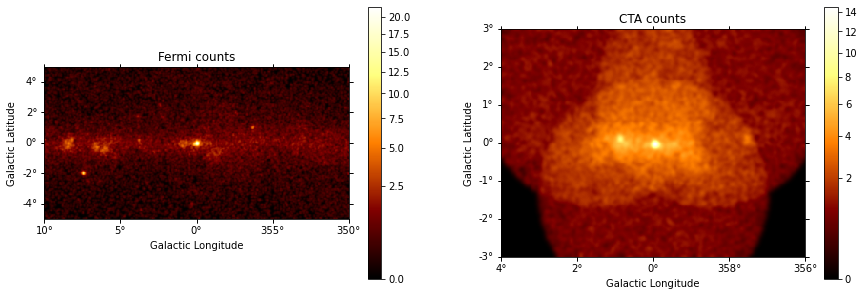

In [5]:
plt.figure(figsize=(15, 5))
ax1 = plt.subplot(121, projection=fermi_dataset.counts.geom.wcs)
ax2 = plt.subplot(122, projection=cta_dataset.counts.geom.wcs)


datasets[0].counts.sum_over_axes().smooth(0.05 * u.deg).plot(
    ax=ax1, stretch="sqrt", add_cbar=True
)
datasets[1].counts.sum_over_axes().smooth(0.05 * u.deg).plot(
    ax=ax2, stretch="sqrt", add_cbar=True
)
ax1.set_title("Fermi counts")
ax2.set_title("CTA counts");

In [6]:
datasets.info_table(cumulative=False)

name,counts,excess,sqrt_ts,background,npred,npred_background,npred_signal,exposure_min,exposure_max,livetime,ontime,counts_rate,background_rate,excess_rate,n_bins,n_fit_bins,stat_type,stat_sum
,,,,,,,,m2 s,m2 s,s,s,1 / s,1 / s,1 / s,,,,
str13,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str4,float64
fermi_dataset,27727,3792.244140625,23.90421023961601,23934.755859375,23934.76235388656,23934.755859375,nan,31375018.0,33704756.0,nan,0.0,nan,nan,nan,880000,633600,cash,nan
cta_dataset,104317,12809.3046875,41.41009347393684,91507.6953125,91507.68628538586,91507.6953125,nan,62842028.0,19024205824.0,5292.0001029780005,5400.0,19.712206721480793,17.291703237308198,2.4205034841725985,768000,691680,cash,nan


In [7]:
print(datasets)

Datasets
--------

Dataset 0: 

  Type       : MapDataset
  Name       : fermi_dataset
  Instrument : 
  Models     : 

Dataset 1: 

  Type       : MapDataset
  Name       : cta_dataset
  Instrument : 
  Models     : 




Note that while the datasets have an associated background map, they currently do not have any associated background model. This will be added in the following section

## Assigning background models to datasets

For any IACT dataset (in this case `cta_dataset`) , we have to create a `FoVBackgroundModel`. Note that `FoVBackgroundModel`
 must be specified to one dataset only

For Fermi-LAT, the background contribution is taken from a diffuse isotropic template. To convert this into a gammapy `SkyModel`, use the helper function `create_fermi_isotropic_diffuse_model()` 

To attach a model on a particular dataset it is necessary to specify the `datasets_names`. Otherwise, by default, the model will be applied to all the datasets in `datasets` 

First, we must create a global `Models` object which acts as the container for all models used in a particular analysis

In [8]:
models = Models()  # global models object

In [9]:
# Create the FoV background model for CTA data

bkg_model = FoVBackgroundModel(dataset_name=cta_dataset.name)
models.append(bkg_model)  # Add the bkg_model to models()

In [10]:
# Read the fermi isotropic diffuse background model

diffuse_iso = create_fermi_isotropic_diffuse_model(
    filename="$GAMMAPY_DATA/fermi_3fhl/iso_P8R2_SOURCE_V6_v06.txt",
)
diffuse_iso.datasets_names = fermi_dataset.name  # specifying the dataset name

In [11]:
models.append(diffuse_iso)  # Add the fermi_bkg_model to models()

In [12]:
# Now, add the models to datasets
datasets.models = models

In [13]:
# You can see that each dataset lists the correct associated models
print(datasets)

Datasets
--------

Dataset 0: 

  Type       : MapDataset
  Name       : fermi_dataset
  Instrument : 
  Models     : ['fermi-diffuse-iso']

Dataset 1: 

  Type       : MapDataset
  Name       : cta_dataset
  Instrument : 
  Models     : ['cta_dataset-bkg']




## Add a model on multiple datasets 

In this section, we show how to add a model to multiple datasets. For this,  we specify a list of `datasets_names` to the model. Alternatively, not specifying any `datasets_names` will add it to all the datasets.

For this example, we use a template model of the galactic diffuse emission to be shared between the two datasets.

In [14]:
# Create the diffuse model
diffuse_galactic_fermi = Map.read(
    "$GAMMAPY_DATA/fermi-3fhl-gc/gll_iem_v06_gc.fits.gz"
)

template_diffuse = TemplateSpatialModel(
    diffuse_galactic_fermi, normalize=False
)  # the template model in this case is already a full 3D model, it should not be normalised

diffuse_iem = SkyModel(
    spectral_model=PowerLawNormSpectralModel(),
    spatial_model=template_diffuse,
    name="diffuse-iem",
    datasets_names=[
        cta_dataset.name,
        fermi_dataset.name,
    ],  # specifying list of dataset names
)  # A power law spectral correction is applied in this case

In [15]:
# Now, add the diffuse model to the global models list
models.append(diffuse_iem)

In [16]:
# add it to the datasets, and inspect
datasets.models = models
print(datasets)

Datasets
--------

Dataset 0: 

  Type       : MapDataset
  Name       : fermi_dataset
  Instrument : 
  Models     : ['fermi-diffuse-iso', 'diffuse-iem']

Dataset 1: 

  Type       : MapDataset
  Name       : cta_dataset
  Instrument : 
  Models     : ['cta_dataset-bkg', 'diffuse-iem']




The `diffuse-iem` model is correctly present on both. Now, you can proceed with the fit. For computational purposes, we skip it in this notebook

In [17]:
#%%time
# fit2 = Fit()
# result2 = fit2.run(datasets)
# print(result2.success)

## Loading models from a catalog

We now load the Fermi 3FHL catalog and demonstrate some convenience functions. For more details on using gammapy catalog, see here[catalogs.ipynb].

In [18]:
from gammapy.catalog import SourceCatalog3FHL

catalog = SourceCatalog3FHL()

We first choose some relevant models from the catalog and create a new `Models` object.

In [19]:
gc_sep = catalog.positions.separation(
    SkyCoord(0, 0, unit="deg", frame="galactic")
)
models_3fhl = [
    _.sky_model() for k, _ in enumerate(catalog) if gc_sep[k].value < 8
]
models_3fhl = Models(models_3fhl)

In [20]:
len(models_3fhl)

20

## Selecting models contributing to a given region

We now use `Models.select_region()` to get a subset of models contributing to a particular region. You can also use `Models.select_mask()` to get models lying inside the `True` region of a mask map`

In [21]:
region = CircleSkyRegion(
    center=SkyCoord(0, 0, unit="deg", frame="galactic"), radius=3.0 * u.deg
)

In [22]:
models_selected = models_3fhl.select_region(region)
len(models_selected)

8

We now want to assign `models_3fhl` to the Fermi dataset, and `models_selected` to both the CTA and Fermi datasets. For this, we explicitlty mention the `datasets_names` to the former, and leave it `None` (default) for the latter.

In [23]:
for model in models_3fhl:
    if model not in models_selected:
        model.datasets_names = fermi_dataset.name

In [24]:
# assign the models to datasets
datasets.models = models_3fhl

To see the models on a particular dataset, you can simply see

In [25]:
print("Fermi dataset models: ", datasets[0].models.names)
print("\n CTA dataset models: ", datasets[1].models.names)

Fermi dataset models:  ['3FHL J1731.7-3003', '3FHL J1732.6-3131', '3FHL J1741.8-2536', '3FHL J1744.5-2609', '3FHL J1745.6-2900', '3FHL J1745.8-3028e', '3FHL J1746.2-2852', '3FHL J1747.2-2959', '3FHL J1747.2-2822', '3FHL J1748.0-2446', '3FHL J1748.1-2903', '3FHL J1748.6-2816', '3FHL J1753.8-2537', '3FHL J1800.5-2343e', '3FHL J1800.7-2357', '3FHL J1801.5-2450', '3FHL J1801.6-2327', '3FHL J1802.3-3043', '3FHL J1809.8-2332', '3FHL J1811.2-2800']

 CTA dataset models:  ['3FHL J1744.5-2609', '3FHL J1745.6-2900', '3FHL J1745.8-3028e', '3FHL J1746.2-2852', '3FHL J1747.2-2959', '3FHL J1747.2-2822', '3FHL J1748.1-2903', '3FHL J1748.6-2816']


## Combining two `Models`

`Models` can be extended simply as as python lists

In [26]:
models.extend(models_selected)
print(len(models))

11


## Selecting models from a list

A `Model` can be selected from a list of `Models` by specifying its index or its name.

In [27]:
model = models_3fhl[0]
print(model)

SkyModel

  Name                      : 3FHL J1731.7-3003
  Datasets names            : fermi_dataset
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.742   +/-    0.50             
    amplitude                     :   2.59e-12   +/- 7.6e-13 1 / (cm2 GeV s)
    reference             (frozen):     17.603       GeV         
    lon_0                         :    262.949   +/-    0.02 deg         
    lat_0                         :    -30.051   +/-    0.02 deg         




In [28]:
# Alternatively
model = models_3fhl["3FHL J1731.7-3003"]
print(model)

SkyModel

  Name                      : 3FHL J1731.7-3003
  Datasets names            : fermi_dataset
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.742   +/-    0.50             
    amplitude                     :   2.59e-12   +/- 7.6e-13 1 / (cm2 GeV s)
    reference             (frozen):     17.603       GeV         
    lon_0                         :    262.949   +/-    0.02 deg         
    lat_0                         :    -30.051   +/-    0.02 deg         




`Models.select` can be used to select all models satisfying a list of conditions.
To select all models applied on the cta_dataset with the characters `1748` in the name

In [29]:
models = models_3fhl.select(
    datasets_names=cta_dataset.name, name_substring="1748"
)
print(models)

Models

Component 0: SkyModel

  Name                      : 3FHL J1748.1-2903
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      4.687   +/-    1.02             
    amplitude                     :   1.24e-11   +/- 3.3e-12 1 / (cm2 GeV s)
    reference             (frozen):     12.596       GeV         
    lon_0                         :    267.037   +/-    0.02 deg         
    lat_0                         :    -29.062   +/-    0.02 deg         

Component 1: SkyModel

  Name                      : 3FHL J1748.6-2816
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      4.345   +/-    0.66             
    amplitude                     :   1.76e-11   +

Note that `Models.select()` combines the different conditions with an `AND` operator. If one needs to combine conditions with a `OR` operator, the `Models.selection_mask()` method can generate a boolean array that can be used for selection. For ex:

In [30]:
selection_mask = models_3fhl.selection_mask(
    name_substring="1748"
) | models_3fhl.selection_mask(name_substring="1731")

models_OR = models_3fhl[selection_mask]
print(models_OR)

Models

Component 0: SkyModel

  Name                      : 3FHL J1731.7-3003
  Datasets names            : fermi_dataset
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.742   +/-    0.50             
    amplitude                     :   2.59e-12   +/- 7.6e-13 1 / (cm2 GeV s)
    reference             (frozen):     17.603       GeV         
    lon_0                         :    262.949   +/-    0.02 deg         
    lat_0                         :    -30.051   +/-    0.02 deg         

Component 1: SkyModel

  Name                      : 3FHL J1748.0-2446
  Datasets names            : fermi_dataset
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      3.480   +/-    0.58             
    amplitude                   

## Removing a model from a dataset

Any addition or removal of a model must happen through the global models object, which must then be re-applied on the dataset(s). Note that operations **cannot** be directly performed on `dataset.models()`.


In [31]:
# cta_dataset.models.remove()
# * this is forbidden *

In [32]:
# Remove the model '3FHL J1744.5-2609'
models_3fhl.remove("3FHL J1744.5-2609")
len(models_3fhl)

19

In [33]:
# After any operation on models, it must be re-applied on the datasets
datasets.models = models_3fhl

To see the models applied on a dataset, you can simply

In [34]:
datasets.models.names

['3FHL J1731.7-3003',
 '3FHL J1732.6-3131',
 '3FHL J1741.8-2536',
 '3FHL J1745.6-2900',
 '3FHL J1745.8-3028e',
 '3FHL J1746.2-2852',
 '3FHL J1747.2-2959',
 '3FHL J1747.2-2822',
 '3FHL J1748.0-2446',
 '3FHL J1748.1-2903',
 '3FHL J1748.6-2816',
 '3FHL J1753.8-2537',
 '3FHL J1800.5-2343e',
 '3FHL J1800.7-2357',
 '3FHL J1801.5-2450',
 '3FHL J1801.6-2327',
 '3FHL J1802.3-3043',
 '3FHL J1809.8-2332',
 '3FHL J1811.2-2800']

### Plotting models on a (counts) map

The spatial regions of `Models` can be plotted on a given geom using `Models.plot_regions()`. You can also use `Models.plot_positions()` to plot the centers of each model.

/Users/terrier/Code/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/regions/shapes/ellipse.py:212: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  return Ellipse(xy=xy, width=width, height=height, angle=angle,
/Users/terrier/Code/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/regions/shapes/ellipse.py:212: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  return Ellipse(xy=xy, width=width, height=height, angle=angle,
/Users/terrier/Code/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/regions/shapes/ellipse.py:212: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  return Ellipse(xy=xy, width=width, height=height, angle=angle,


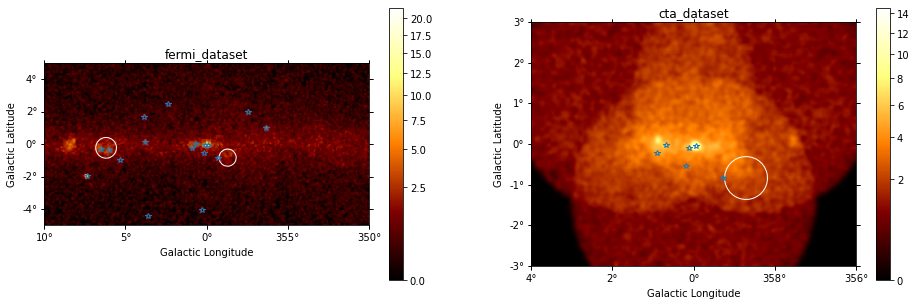

In [35]:
plt.figure(figsize=(16, 5))
ax1 = plt.subplot(121, projection=fermi_dataset.counts.geom.wcs)
ax2 = plt.subplot(122, projection=cta_dataset.counts.geom.wcs)

for ax, dataset in zip([ax1, ax2], datasets):
    dataset.counts.sum_over_axes().smooth(0.05 * u.deg).plot(
        ax=ax, stretch="sqrt", add_cbar=True, cmap="afmhot"
    )
    dataset.models.plot_regions(ax=ax, color="white")
    ax.set_title(dataset.name);

## Freezing and unfreezing model parameters

For a given model, any parameter can be (un)frozen individually. Additionally, `model.freeze` and `model.unfreeze` can be used to freeze and unfreeze all parameters in one go.

In [36]:
model = models_3fhl[0]
print(model)

SkyModel

  Name                      : 3FHL J1731.7-3003
  Datasets names            : fermi_dataset
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.742   +/-    0.50             
    amplitude                     :   2.59e-12   +/- 7.6e-13 1 / (cm2 GeV s)
    reference             (frozen):     17.603       GeV         
    lon_0                         :    262.949   +/-    0.02 deg         
    lat_0                         :    -30.051   +/-    0.02 deg         




In [37]:
# To freeze a single parameter
model.spectral_model.index.frozen = True
print(model)  # index is now frozen

SkyModel

  Name                      : 3FHL J1731.7-3003
  Datasets names            : fermi_dataset
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                 (frozen):      2.742                   
    amplitude                     :   2.59e-12   +/- 7.6e-13 1 / (cm2 GeV s)
    reference             (frozen):     17.603       GeV         
    lon_0                         :    262.949   +/-    0.02 deg         
    lat_0                         :    -30.051   +/-    0.02 deg         




In [38]:
# To unfreeze a parameter
model.spectral_model.index.frozen = False

In [39]:
# To freeze all parameters of a model
model.freeze()
print(model)

SkyModel

  Name                      : 3FHL J1731.7-3003
  Datasets names            : fermi_dataset
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                 (frozen):      2.742                   
    amplitude             (frozen):   2.59e-12       1 / (cm2 GeV s)
    reference             (frozen):     17.603       GeV         
    lon_0                 (frozen):    262.949       deg         
    lat_0                 (frozen):    -30.051       deg         




In [40]:
# To unfreeze all parameters (except parameters which must remain frozen)
model.unfreeze()
print(model)

SkyModel

  Name                      : 3FHL J1731.7-3003
  Datasets names            : fermi_dataset
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.742   +/-    0.50             
    amplitude                     :   2.59e-12   +/- 7.6e-13 1 / (cm2 GeV s)
    reference             (frozen):     17.603       GeV         
    lon_0                         :    262.949   +/-    0.02 deg         
    lat_0                         :    -30.051   +/-    0.02 deg         




Only spectral or spatial or temporal components of a model can also be frozen

In [41]:
# To freeze spatial components
model.freeze("spatial")
print(model)

SkyModel

  Name                      : 3FHL J1731.7-3003
  Datasets names            : fermi_dataset
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.742   +/-    0.50             
    amplitude                     :   2.59e-12   +/- 7.6e-13 1 / (cm2 GeV s)
    reference             (frozen):     17.603       GeV         
    lon_0                 (frozen):    262.949       deg         
    lat_0                 (frozen):    -30.051       deg         




To check if all the parameters of a model are frozen, 

In [42]:
model.frozen  # False because spectral components are not frozen

False

In [43]:
model.spatial_model.frozen  # all spatial components are frozen

True

The same operations can be performed on `Models` directly - to perform on a list of models at once, eg

In [44]:
models_selected.freeze()  # freeze all parameters of all models

In [45]:
models_selected.unfreeze()  # unfreeze all parameters of all models

In [46]:
# print the free parameters in the models
models_selected.parameters.free_parameters.names

['index',
 'amplitude',
 'lon_0',
 'lat_0',
 'index',
 'amplitude',
 'lon_0',
 'lat_0',
 'index',
 'amplitude',
 'lon_0',
 'lat_0',
 'r_0',
 'index',
 'amplitude',
 'lon_0',
 'lat_0',
 'index',
 'amplitude',
 'lon_0',
 'lat_0',
 'index',
 'amplitude',
 'lon_0',
 'lat_0',
 'index',
 'amplitude',
 'lon_0',
 'lat_0',
 'index',
 'amplitude',
 'lon_0',
 'lat_0']

There are more functionalities which you can explore. In general, using `help()` on any function is a quick and useful way to access the documentation. For ex, `Models.unfreeze_all` will unfreeze all parameters, even those which are fixed by default. To see its usage, you can simply type

In [47]:
help(models_selected.unfreeze)

Help on method unfreeze in module gammapy.modeling.models.core:

unfreeze(model_type=None) method of gammapy.modeling.models.core.Models instance
    Restore parameters frozen status to default depending on model type
    
    Parameters
    ----------
    model_type : {None, "spatial", "spectral"}
       restore frozen status to default for all parameters or only spatial or only spectral



## Serialising models

`Models` can be (independently of `Datasets`) written to/ read from a disk as yaml files. 
Datasets are always serialised along with their associated models, ie, with yaml and fits files.
eg:

In [48]:
# To save only the models
models_3fhl.write("3fhl_models.yaml", overwrite=True)

In [49]:
# To save datasets and models
datasets.write(filename="datasets-gc.yaml", overwrite=True)

In [50]:
# To read only models
models = Models.read("3fhl_models.yaml")
print(models)

Models

Component 0: SkyModel

  Name                      : 3FHL J1731.7-3003
  Datasets names            : fermi_dataset
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.742   +/-    0.50             
    amplitude                     :   2.59e-12   +/- 7.6e-13 1 / (cm2 GeV s)
    reference             (frozen):     17.603       GeV         
    lon_0                 (frozen):    262.949       deg         
    lat_0                 (frozen):    -30.051       deg         

Component 1: SkyModel

  Name                      : 3FHL J1732.6-3131
  Datasets names            : fermi_dataset
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      5.151   +/-    0.84             
    amplitude                     :   2.78e-11  

In [51]:
# To read datasets with models
datasets_read = Datasets.read("datasets-gc.yaml")
print(datasets)

Datasets
--------

Dataset 0: 

  Type       : MapDataset
  Name       : fermi_dataset
  Instrument : 
  Models     : ['3FHL J1731.7-3003', '3FHL J1732.6-3131', '3FHL J1741.8-2536', '3FHL J1745.6-2900', '3FHL J1745.8-3028e', '3FHL J1746.2-2852', '3FHL J1747.2-2959', '3FHL J1747.2-2822', '3FHL J1748.0-2446', '3FHL J1748.1-2903', '3FHL J1748.6-2816', '3FHL J1753.8-2537', '3FHL J1800.5-2343e', '3FHL J1800.7-2357', '3FHL J1801.5-2450', '3FHL J1801.6-2327', '3FHL J1802.3-3043', '3FHL J1809.8-2332', '3FHL J1811.2-2800']

Dataset 1: 

  Type       : MapDataset
  Name       : cta_dataset
  Instrument : 
  Models     : ['3FHL J1745.6-2900', '3FHL J1745.8-3028e', '3FHL J1746.2-2852', '3FHL J1747.2-2959', '3FHL J1747.2-2822', '3FHL J1748.1-2903', '3FHL J1748.6-2816']


